In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np 
from scipy.stats import norm, multivariate_normal
from typing import Any, Dict, List

# Custom code
from src.synthetic.coordination_generator import DiscreteCoordinationGeneratorASIST
from src.synthetic.vocalics_generator import VocalicsGeneratorForDiscreteCoordinationASIST
from src.transformations.series_transformations import embed_features_across_dimensions
from src.inference.vocalics import DiscreteCoordinationInference

# Binary Coordination (hard coupling)

We start with coordination as a binary variable. Vocalic series A and B are observed at different time scales. A single value of this series at a time step $t$ contains the average value of a specific vocalic feature whithin an utterance that ended at time $t$. If no utterance ended at that time, there's no link between the coordination variable and the vocalic series. That means the model structure is defined according to the data. The existance of coordination affects the coupling between series $A$ and $B$, that is, whether $B_t$ depends on $A_{t-1}$ and vice versa. 

Let's define the following distributions:

$
\begin{align}
p(C_0) &= 0 ~\text{We assume participants start uncoordinated} \\
p(C_t|C_{t-1}) &= \begin{cases}
(1 - C_t)^{p_c}C_{t}^{1 - p_c} ~~\text{if}~~ C_{t-1} = 0 \\
(1 - C_t)^{1 - p_c}C_{t}^{p_c} ~~\text{if}~~ C_{t-1} = 1 
\end{cases}\\
p(A_t|A_{t-1}, B_t{t-1}, C_t) &= \mathcal{N}(A_t;A_{t-1},\sigma_A)^{1-C_t}\mathcal{N}(A_t;B_{t-1},\sigma^2_{AB})^{C_t}\\
p(B_t|B_{t-1}, A_t{t-1}, C_t) &= \mathcal{N}(B_t;B_{t-1},\sigma_B)^{1-C_t}\mathcal{N}(B_t;A_{t-1},\sigma^2_{AB})^{C_t}
\end{align}
$

To start, we can normalize the series A and B sunch that they have mean 0 and standard deviation 1. And we can set $\sigma_A$ and $\sigma_B$ to 0. Let us also assume at this point that the variance component of the coupled system is unitary. That is, $\sigma_{AB} = 1$. 

## Inference

Based on the observed vocalic series component, we can infer the coordination at each time step. The joint distribution of coordination and vocalics components is

$
\begin{align}
p(C_{0:M}, A_{0,T}, B_{0,T}) = p(C_0)p(A_0)p(B_0)&\prod^{M-1}_{t=1}p(C_t|C_{t-1})p(A_t|A_{t-1},B_{t-1},C_t)p(B_t|B_{t-1}, A_{t-1},C_t)\\
&p(C_M|C_{M-1})\prod^{T}_{t=M}p(A_t|A_{t-1},B_{t-1},C_M)p(B_t|B_{t-1}, A_{t-1},C_M)
\end{align}
$

Notice that for a certain $t$, $A_t$ and $B_t$ might not have been observed, which means we do not include their terms in the equation above, or they are replaced by 1 which has the same effect. Also, $B_{t-1}$ and $A_{t-1}$ refer to the last time values for the series were observed, thus that might not correspond to the actual $t-1$ time step. 

Inference here can be performed exactly using message passing because of the discrete nature of coordination.

## Synthetic Data

Let us start by generating coordination and vocalics samples for a synthetic set and see the inference working in practice.

In [3]:
# Constants
SEED = 0 # For reproducibility
T = 100
M = int(T/2)
PC = 0.9 # Coordination is likely to be preserved from one time step to the next

In [4]:
# Plot functions
def plot_coordination(cs: List[float]):
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(cs)), cs, color="green")
    plt.title("Synthetic Discrete Coordination")
    
def plot_vocalic_series(series_a: List[float], series_b: List[float], marker: str = "o", 
                        ax: Any = None):
    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = plt.gca()
    
    plt.scatter(range(len(series_a)), series_a, color="blue", label="A", marker=marker)
    plt.scatter(range(len(series_b)), series_b, color="orange", label="B", marker=marker)
    plt.legend()        
    
    return ax

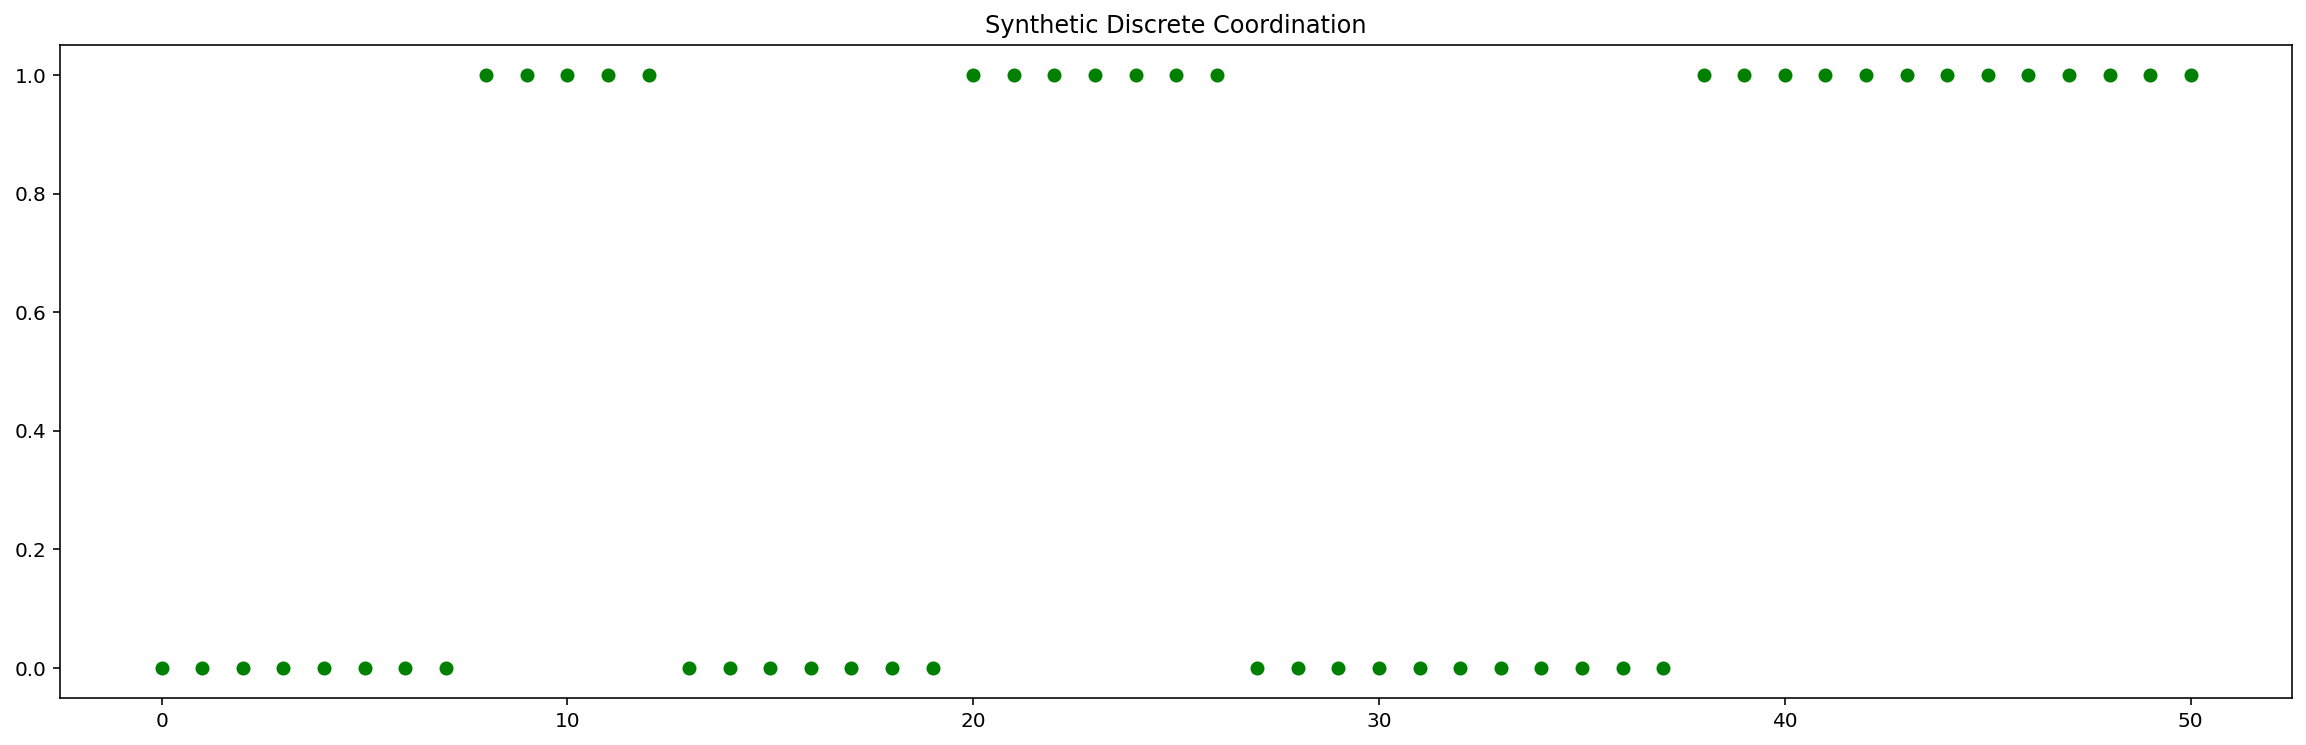

In [5]:
random.seed(SEED)
np.random.seed(SEED)
discrete_cs = np.array(DiscreteCoordinationGeneratorASIST(p_prior = 0, pc = PC).generate_evidence(T))
discrete_cs[M:] = discrete_cs[M]
plot_coordination(discrete_cs[:M+1])

Text(0.5, 1.0, 'Synthetic Intensity')

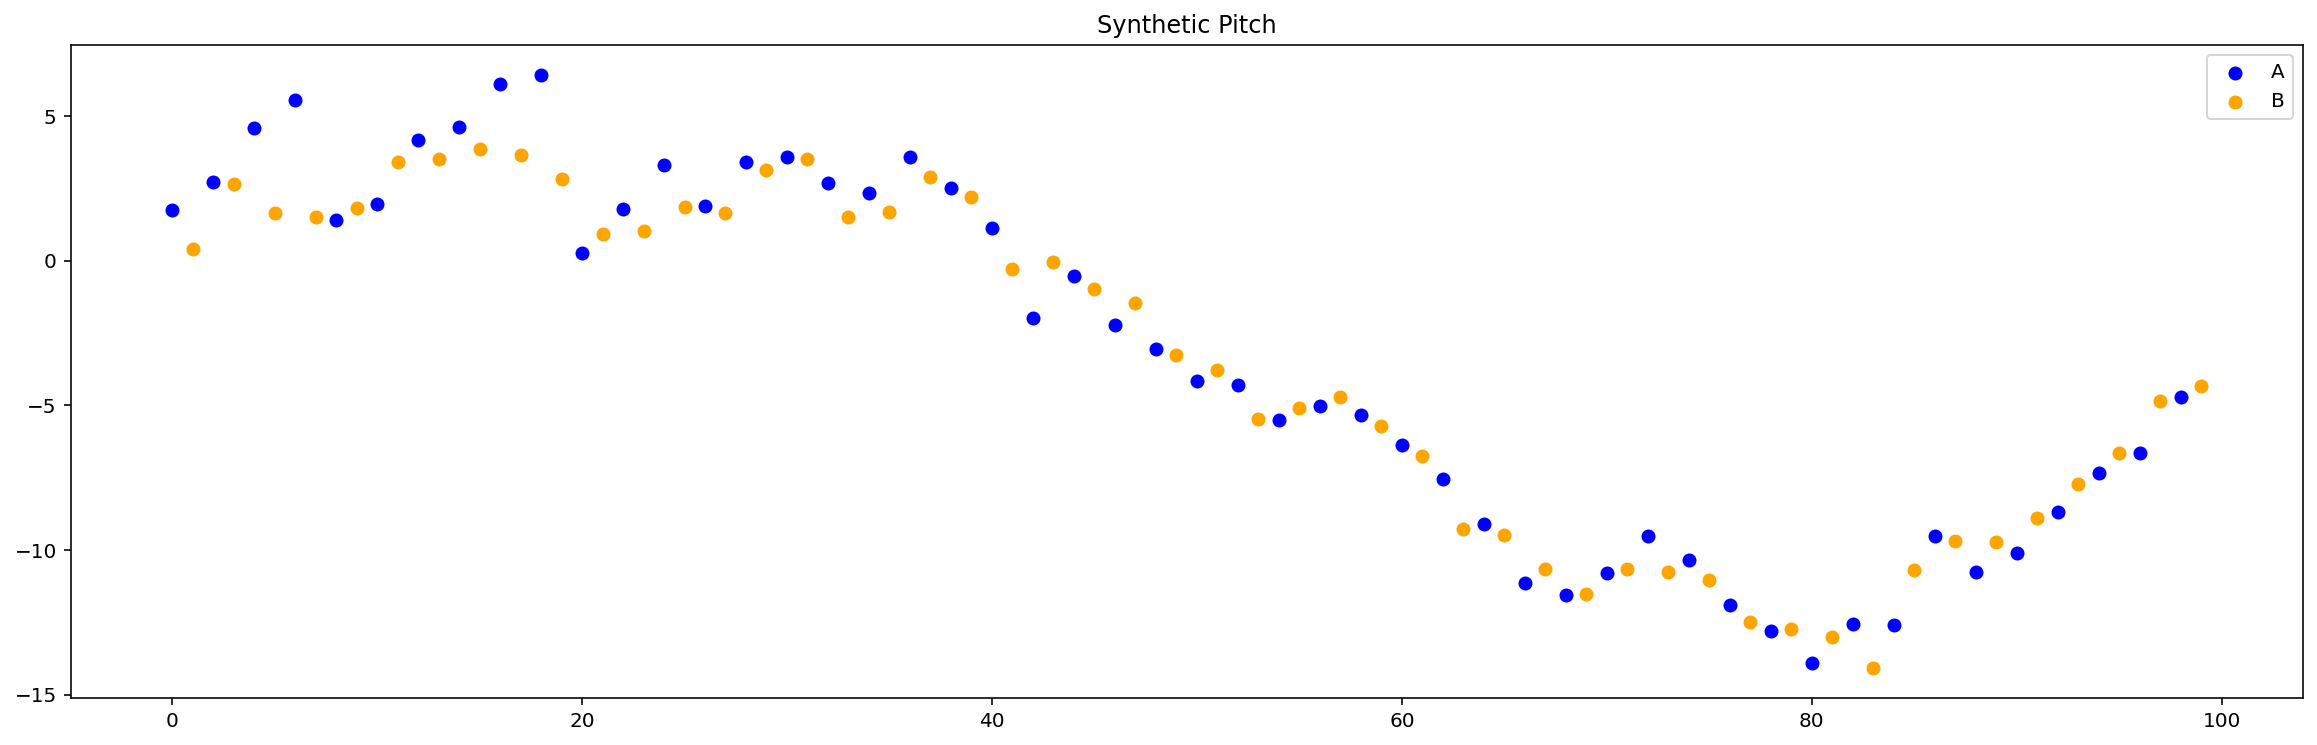

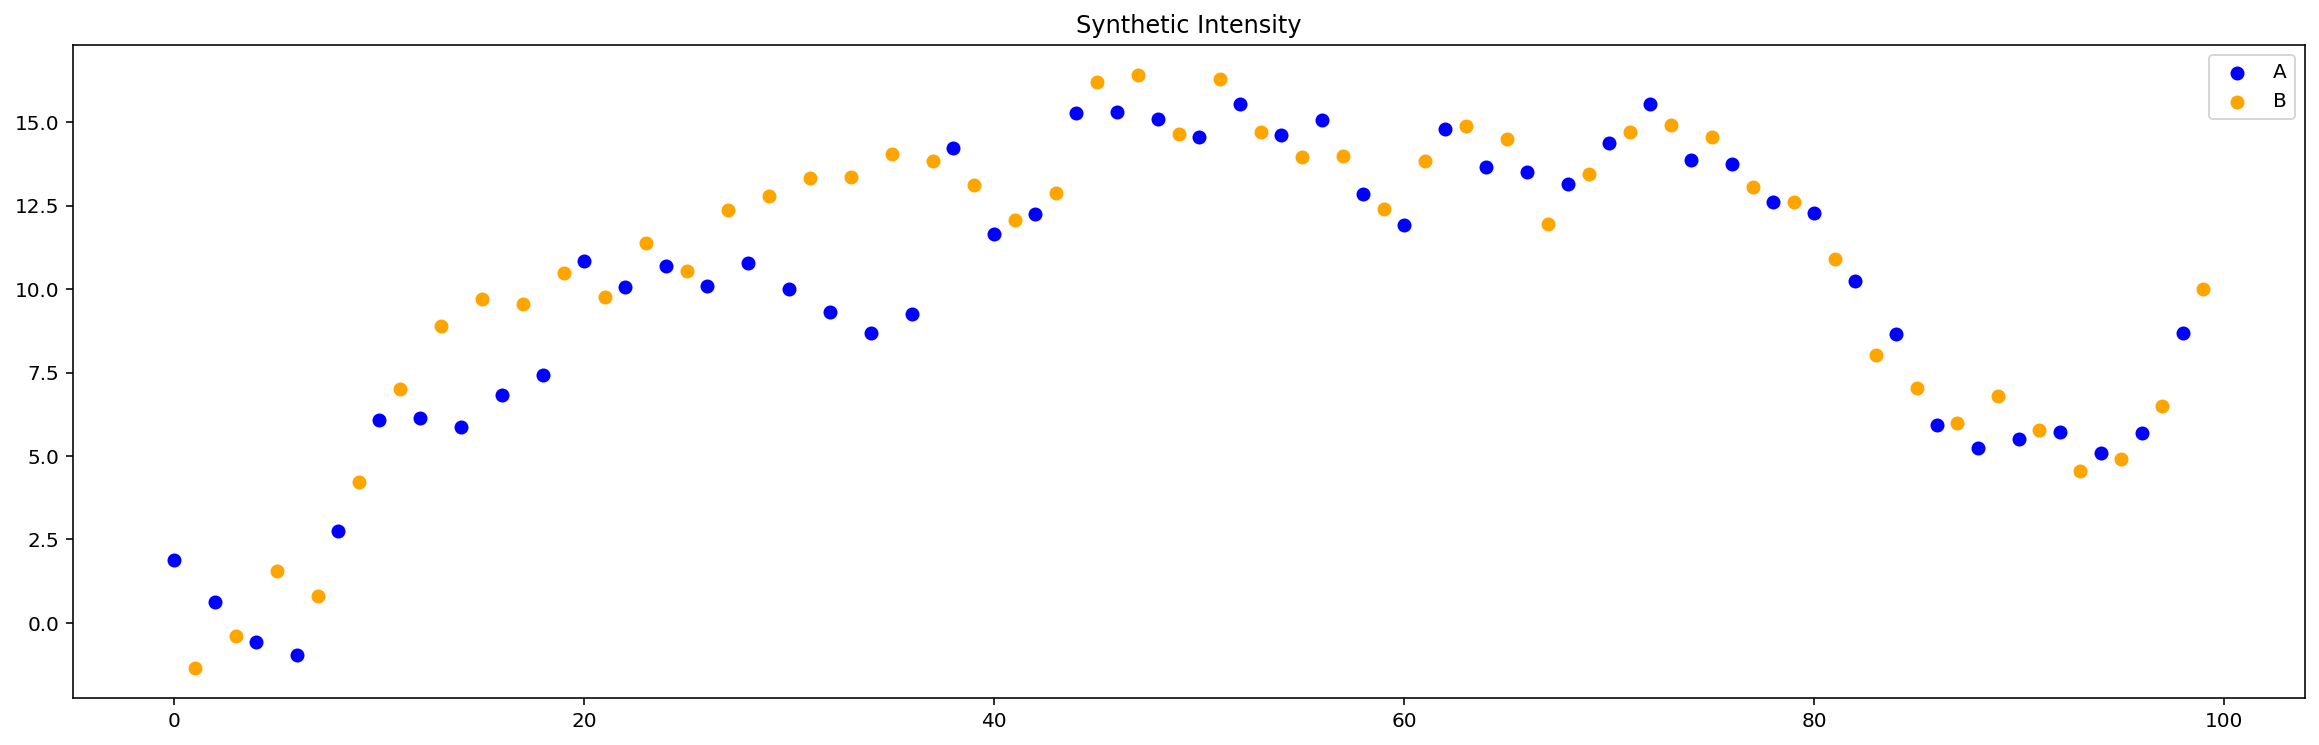

In [6]:
random.seed(SEED)
np.random.seed(SEED)
vocalics_generator = VocalicsGeneratorForDiscreteCoordinationASIST(coordination_series=discrete_cs, 
                                                              vocalic_features=["pitch", "intensity"], 
                                                              time_scale_density=1, 
                                                              mean_shift_coupled=0,
                                                              var_coupled=1)
series_a, series_b = vocalics_generator.generate_evidence()
ax_pitch = plot_vocalic_series(series_a["pitch"], series_b["pitch"])
ax_pitch.set_title("Synthetic Pitch")
ax_pitch = plot_vocalic_series(series_a["intensity"], series_b["intensity"])
ax_pitch.set_title("Synthetic Intensity")

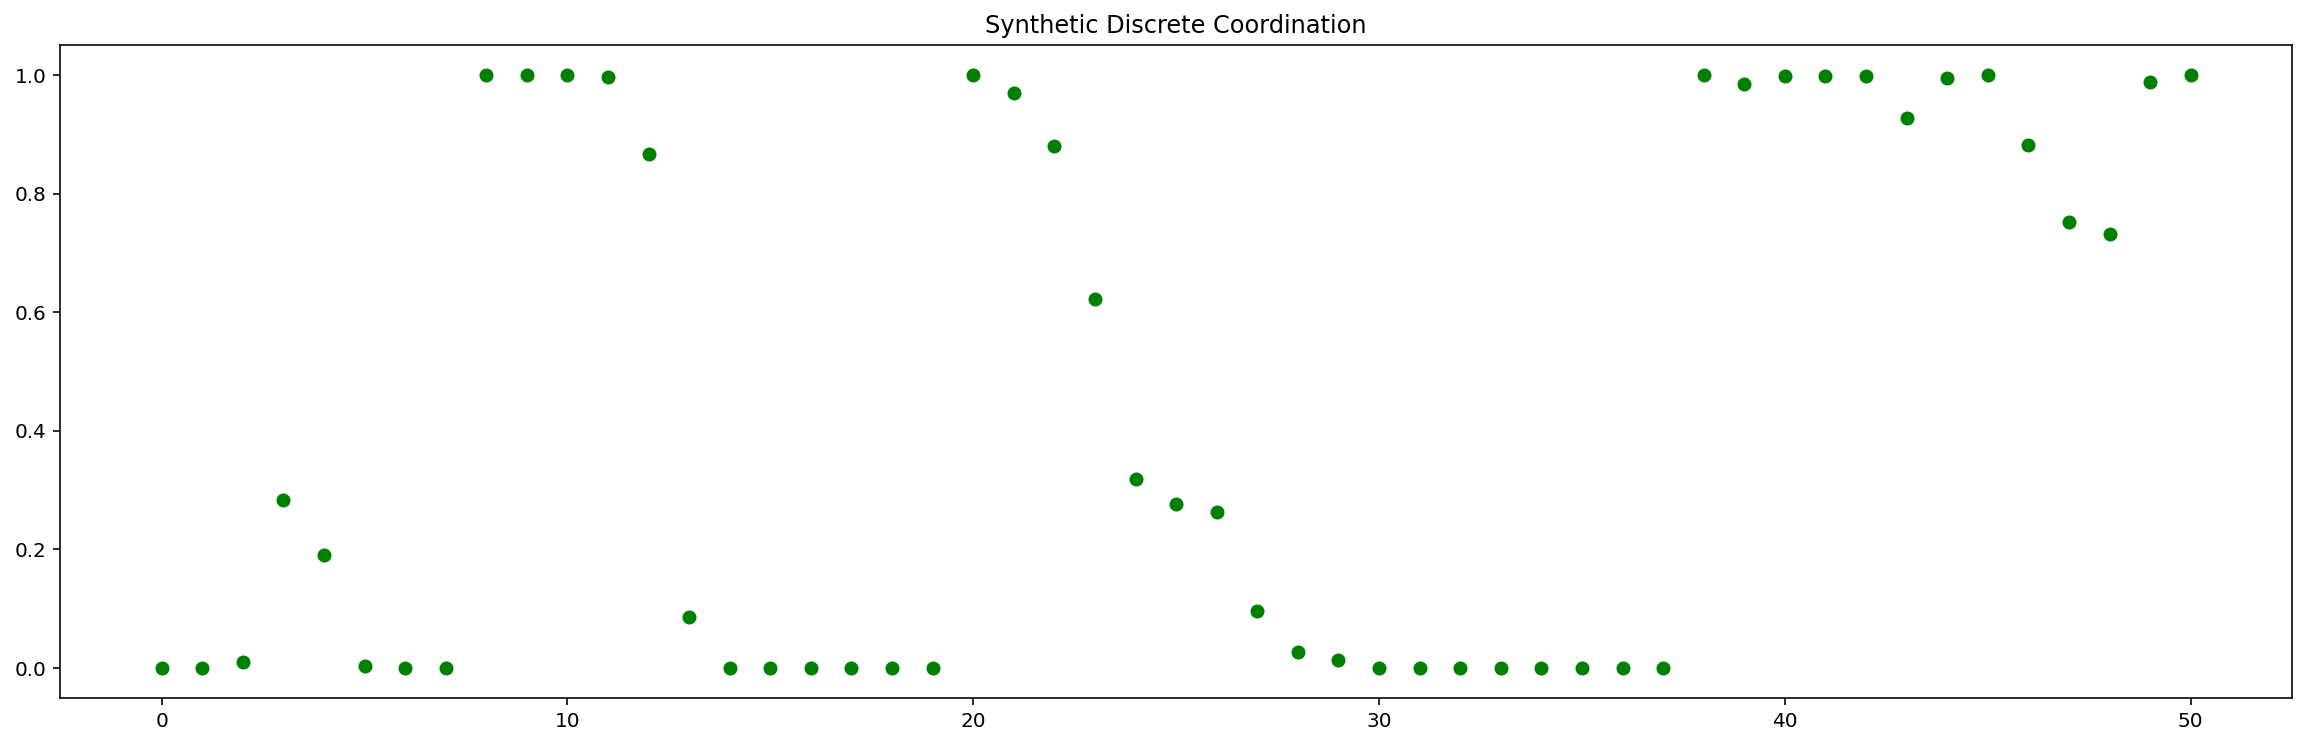

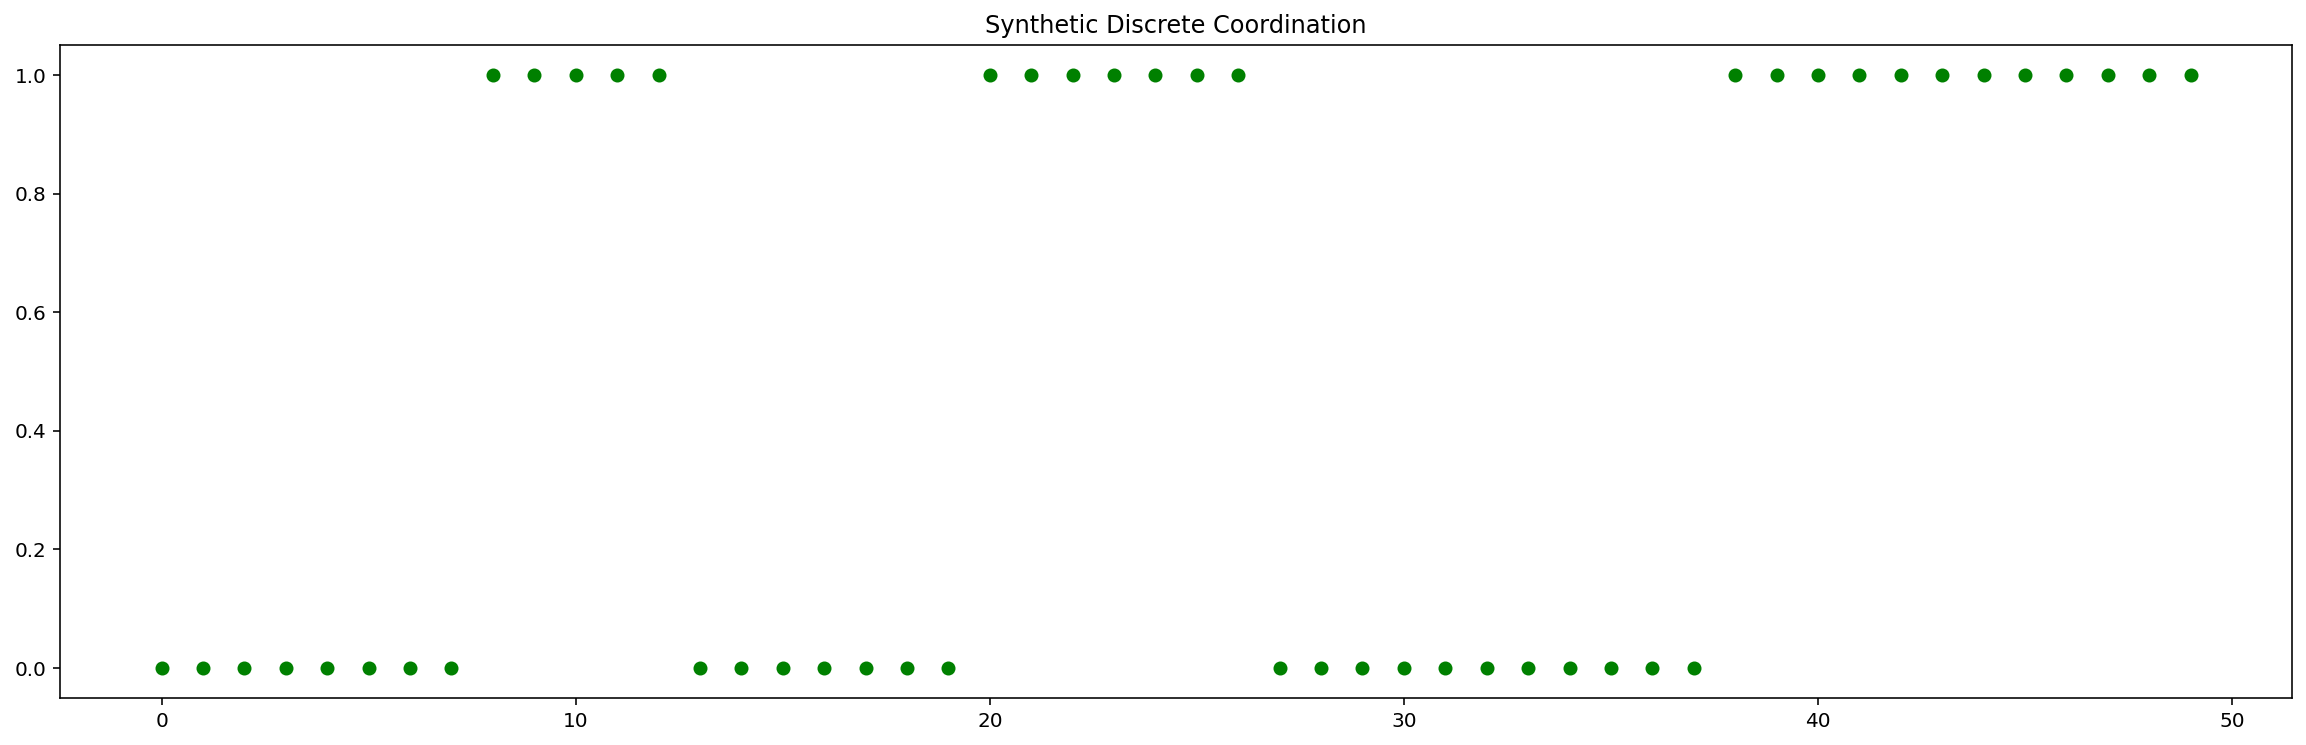

In [7]:
multi_dim_a, mask_a = embed_features_across_dimensions(T, series_a)
multi_dim_b, mask_b = embed_features_across_dimensions(T, series_b)
inference_engine = DiscreteCoordinationInference(multi_dim_a.T, multi_dim_b.T, 0, PC, 0, 1, 0, 1, 1, mask_a, mask_b)
marginals = inference_engine.estimate_marginals()

plot_coordination(marginals[:, 1])
plot_coordination(discrete_cs[:M])